# **Comparison between Onset Detection approaches**

This IPYNB notebook performs a comparison of different Onset Detection techniques on the ODB dataset, downloaded from the page of Pattern Recognition and Artificial Intelligence Group, Universidad de Alicante (https://grfia.dlsi.ua.es). The original files can be separately accessed here: https://grfia.dlsi.ua.es/cm/worklines/pertusa/onset/ODB/. A .zip file containing the data can be found in my Github page for ease of access here: https://github.com/leboucletoledo/DT2470_MusicInformatics/blob/master/Project/Data/ODB.zip.

The explored Onset Detection techniques include the Spectral-Based and Complex Domain Novelty Functions, using two different frameworks for Peak Detection: a simple threshold, and an implementation of the Music Structure Analysis Framework (MSAF), as proposed by Bello et Nieto (2016) in their paper "Systematic Exploration of Computational Music Structure Research".

This notebook also makes use of Madmom's tools for Onset Detection, using an implementation of its RNN Onset Processor for the task. It also uses its Evaluation tools for obtaining metrics in order to assess the results.

## **1. Install Libraries for Google Colab**

In order to run this notebook in Colab, some Python libraries have to be imported. In order to use Madmom, the Runtime has to be restarted so the library can be used. 

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install --force-reinstall madmom
    !pip install pydub
    # !pip install librosa

  Using cached madmom-0.16.1-cp37-cp37m-linux_x86_64.whl
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached mido-1.2.10-py2.py3-none-any.whl (51 kB)
  Using cached Cython-0.29.24-cp37-cp37m-manylinux1_x86_64.whl (2.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.1
    Uninstalling scipy-1.7.1:
      Successfully uninstalled scipy-1.7.1
  Attempting uninstall: mido
    Found existing installation: mido 1.2.10
    Uninstalling mido-1.2.10:
      Successfully uninstalled mido-1.2.10
  Attempting uninstall: cython
    Found existing installation: Cython 0.29.24
    Uninstalling Cython-0.29.24:
      Successfully uninstalled Cython-0.29.24
  Attempting uninstall: 

##**2. Import Python Libraries and mount Google Drive**

For ease of access, the notebook uses Google Drive as the container for the dataset. You will have to upload it yourself and indicate in the *COLAB_FOLDER* variable the location of such folder.

In [ ]:
import os, sys
import shutil
from scipy import signal
import pydub
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# import librosa
# import librosa.display
import madmom as mdm
from scipy.ndimage import filters
import time
import xml.etree.ElementTree as ET
import IPython.display as ipd
import IPython.core.display as ipd_core
import pandas as pd
from tqdm.notebook import tqdm

ROOT = '/content/drive/'

'''
If using Google Drive, change Folder where dataset is contained
'''
DATA_FOLDER = 'My Drive/DT2470 - Project/ODB/'

COLAB_FOLDER = os.path.join(ROOT, DATA_FOLDER)

if IN_COLAB:
    from google.colab import drive
    drive.mount(ROOT)

Mounted at /content/drive/


## **3. Dataset Management**

If Jupyter Lab/Notebook is being used, the *ANNOTATIONS* and *AUDIO* variables must be entered manually with the corresponding directories for such files.

If Google Colab is being used, it will automatically create the folders and import the .txt and .wav files from Google Drive.

In [ ]:
if IN_COLAB:
    # Delete folders for fresh start
    !rm -rf ./dataset

    if not os.path.exists('./dataset'):
        os.mkdir('./dataset')

    if not os.path.exists('./dataset/ODB'):
        os.mkdir('./dataset/ODB')
        os.mkdir('./dataset/ODB/audio')
        os.mkdir('./dataset/ODB/annotations')

    ANNOTATIONS =   './dataset/ODB/annotations/'
    AUDIO =         './dataset/ODB/audio/'

    for root, dirs, files in os.walk(COLAB_FOLDER):
        for file in files:
            if file.endswith('.wav'):
                # print(os.path.join(root, file))
                shutil.copy2(os.path.join(root, file), AUDIO)

            if file.endswith(".txt"):
                # print(os.path.join(root, file))
                shutil.copy2(os.path.join(root, file), ANNOTATIONS)
else:
    '''
    Type in the folder directories where the .txt annotations and .wav audio
    are contained
    '''
    ANNOTATIONS = ''
    AUDIO = ''

Confirm that we have same number of annotations and files

In [ ]:
num_audio = len([name for name in os.listdir(AUDIO) if os.path.isfile(os.path.join(AUDIO, name))])
num_annot = len([name for name in os.listdir(ANNOTATIONS) if os.path.isfile(os.path.join(ANNOTATIONS, name))])

if num_audio != num_annot:
    print('Number of audio files and annotations do not match, please load again')
else:
    print('Matching number of audio files and annotations ({}, {})'.format(num_audio, num_annot))

Matching number of audio files and annotations (19, 19)


Collect all annotations for each file in a dictionary with their corresponding names for matching purposes.

In [ ]:
dict_annotations = {}

for file in os.listdir(ANNOTATIONS):
    name = os.path.splitext(os.path.basename(ANNOTATIONS + file))[0] # Get the name of the file
    data = pd.read_csv(ANNOTATIONS + file, header = None) # Obtain the annotations for each file
    dict_annotations[name] = data[0]  # Add annotations to the file name

## **4. Methods**

### 4.1 <ins>Wave Class definition</ins> 

**STFT**
Uses SciPy framework to obtain an STFT from the anaylized wave signal. For simplicity, the Hann window is used entirely throughout the experimentation. 
It has the option to return the absolute magnitude values for the STFT.

**Local Average Function**
Used for improving the Spectral-Based Novelty function by enhancing the peak structure and supressing small fluctuations that could cause false positives.

**Spectral-Based Novelty**
The Spectral-Based Novelty, or spectral flux, detection uses the output of the STFT to identify changes in the frequency representation, this is by computing a distance measure between spectral vectors that are contained in a specific analysis window. Enhanced with the use of Local Average Function.

**Complex-Domain Novelty**
The Complex-Domain Novelty uses both the magnitude of the spectral coefficient and the phase information of the signal, weighing both of them in a variation of the spectral novelty function. For this variant it is assumed that phase and magnitude are somewhat constant in steady regions of the signal. Enhanced with the use of Local Average Function.

**Madmom Onset Detection**
Uses Madmom's Onseat Peak Picking Processor and a RNN Onset Processor to obtain onset positions for a given file. The arguments for this method determines how the peaks will be transformed to frames.

**Single-case Analysis**
This analysis uses the 5 proposed onset detection methods to obtain plots that help visualize which onsets were corrently identified (True Positives), which were not properly identified (False Negatives), and if any onsets were detected where there should not have been any (False Positives).

**Plot Signals**
Two methods for plotting the wave signal are included, the second method allowing for plotting with the detected peaks which assists with annotation comparison. These are used for the Single-case Analysis method, and include the spectral-novelty function used except for Madmom's Onset detection.


In [ ]:
class Wave(object):
    def __init__(self, folder='', file_name='', frame_size_sec = 0.030, hop_size_sec = 0.010):
        '''
        Args:
            folder: string with folder location of audio file
            file_name: string with name of audio file
            frame_size_sec: STFT frame size in seconds
            hop_size_sec: STFT hop size in seconds
        '''
        self.file_name = file_name
        self.folder = folder
        # Obtain array for audio file
        self.x = pydub.AudioSegment.from_file(self.folder + self.file_name, format='wav')
        self.x_arr = (np.array(self.x.get_array_of_samples()) / 2**16) * 2
        # Sample rate for audio file
        self.sr = self.x.frame_rate
        # Check for stereo, use only left channel
        if self.x.channels ==2:
            print("File contains two channels, reducing to one channel...")
            channel_left = self.x_arr[::2]
            channel_right = self.x_arr[1::2]
            self.x_arr = channel_left
        # Calculate frame size, hop size, STFT sample rate and time array for audio file
        self.frame_size = int(frame_size_sec * self.sr)
        self.hop_size = int(hop_size_sec * self.sr)
        self.sr_nov = self.sr / self.hop_size
        self.time = np.linspace(0, len(self.x_arr) / (self.sr), num=len(self.x_arr))

    def STFT(self, abs_mag=True):
        '''
        Args:
            abs_mag: boolean for returning STFT with absolute values
        Returns:
            stft: Short-Term Fourier Transform of Wave object
            stft_mag: STFT with calculated absolute values (magnitudes)
            freq: Array of sample frequencies in KHz
            time: Array of segment times
        '''
        freq, time, stft = signal.stft(self.x_arr, 
                                        fs=self.sr, 
                                        window='hann', 
                                        nfft= self.frame_size, 
                                        nperseg=self.frame_size, 
                                        noverlap=(self.frame_size - self.hop_size)
                                        )    
        # Convert freq array to KHz
        freq /= 1000
        
        if abs_mag:
            stft_mag = np.abs(stft)
            return stft_mag, freq, time
        else:
            return stft, freq, time

    def localAverageFunction(self, spec_nov, M_sec):
        '''
        Args:
            spec_nov: rectified spectral novelty function
            M_sec: averaging window in seconds
        Returns:
            loc_avg: array with local averages
        '''
        
        # Use STFT calculated sample rate
        M = int(np.ceil(self.sr_nov * M_sec))
        L = spec_nov.shape[0]
        loc_avg = np.zeros(L)
        
        for m in range(L):
            a = max(m - M, 0)
            b = min(m + M + 1, L)
            loc_avg[m] = (1 / (2 * M + 1)) * np.sum(spec_nov[a:b])
        
        return loc_avg

    def spectralBasedNovelty(self, gamma=100, M_sec=0.2):
        '''
        Args:
            gamma: positive constant for logarithmic compression
            M_sec: averaging window in seconds
        Returns:
            novelty_enhanced: enhanced spectral-based novelty function
        '''

        stft, freq, time = self.STFT()
        spec_comp = np.log(1 + gamma * stft)

        K = spec_comp.shape[0]
        N = spec_comp.shape[1]

        mat_diff = np.zeros_like(spec_comp)

        for k in range(K):
            arr_diff = np.zeros(N)
            arr_diff[1:] = np.diff(spec_comp[k])
            mat_diff[k] = np.max([np.zeros(N), arr_diff], axis=0)
        
        spec_novelty = np.sum(mat_diff, axis=0)
        local_average = self.localAverageFunction(spec_novelty, M_sec)
        novelty_enhanced = np.max([np.zeros_like(spec_novelty), 
                                   (spec_novelty - local_average)], 
                                  axis=0) / np.amax(spec_novelty)
    
        return novelty_enhanced

    def complexDomainNovelty(self, gamma=100, M_sec=0.2):
        '''
        Args:
            gamma: positive constant for logarithmic compression
            M_sec: averaging window in seconds
        Returns:
            novelty_complex: complex-domain novelty
        '''
        X, _, _ = self.STFT(abs_mag=False)
        X_mag = np.abs(X)
        X_mag = np.log(1 + gamma * X_mag)
        
        # Phase calculation
        phase = np.angle(X) / (2 * np.pi)
        phase_diff = np.diff(phase, axis=1)
        phase_diff = np.concatenate((phase_diff, np.zeros((phase.shape[0], 1))), axis=1)
        X_hat = X_mag * np.exp(2 * np.pi * 1j * (phase + phase_diff))
        X_prime = np.abs(X_hat - X)
        X_plus = np.copy(X_prime)
        X_minus = np.copy(X_prime)
        
        # Rectification
        for n in range(1, X.shape[0]):
            idx_plus = np.where(X_mag[n,:] <= X_mag[n-1,:])
            idx_minus = np.where(X_mag[n,:] > X_mag[n-1,:]) 
            X_plus[n, idx_plus] = 0
            X_minus[n, idx_minus] = 0
        novelty_complex = np.sum(X_plus, axis=0)      
        
        # Use local average function
        local_average = self.localAverageFunction(novelty_complex, M_sec)
        novelty_complex =  novelty_complex - local_average
        novelty_complex[novelty_complex<0]=0
        
        # Normalization
        novelty_complex = novelty_complex / np.max(novelty_complex)

        return novelty_complex

    def findPeaks(self, x, peak_type='simple', 
                  threshold=None, median_len=16, 
                  offset_rel=0.05, sigma=4):
        '''
        Args:
            x: input novelty function
            peak_type: simple or MSAF peak type selection
            threshold: lower linear threshold for simple peak detection
            median_len: length of filter for adaptive thresholding
            offset_rel: offset for adaptive thresholding
            sigma: variance for Gaussian kernel
        Returns:
            peaks_arr: array with detected peak positions
            x: novelty function; smoothened if MSAF is used
            thrshld_arr: threshold array
        '''
        peaks = []
        # Select peaks based on a preset threshold
        if peak_type=='simple':
            if threshold is None:
                threshold = np.min(x) - 1
            for i in range(1, x.shape[0] - 1):
                if x[i - 1] < x[i] and x[i] > x[i + 1]:
                    if x[i] >= threshold:
                        peaks.append(i)
            thrshld_arr = np.ones(x.shape) * threshold
        
        # Use smoothening and an adaptive threshold
        elif peak_type=='MSAF':
            offset = x.mean() * offset_rel
            x = filters.gaussian_filter1d(x, sigma=sigma)
            threshold_local = filters.median_filter(x, size=median_len) + offset
            for i in range(1, x.shape[0] - 1):
                if x[i - 1] < x[i] and x[i] > x[i + 1]:
                    if x[i] > threshold_local[i]:
                        peaks.append(i)
            thrshld_arr = threshold_local

        else:
            print('Error: unrecognized peak type [simple, MSAF]')
            return 0
        
        # Obtain peak positions with regard to STFT sample rate
        peaks_arr = np.array(peaks) / self.sr_nov
                
        return peaks_arr, x, thrshld_arr

    def madmomOnsetDeepLearning(self, thrs_RNN, smooth_factor,  
                                pre_avg, post_avg, pre_max, post_max,
                                combine, fps):
        '''
        Args:
            thrs_RNN:: threshold for peak-picking
            smooth_factor: activation function smoothening in seconds
            pre_avg: moving average past information in seconds 
            post_avg: moving average future information in seconds
            pre_max: moving maximum past information in seconds
            post_max: moving minimum future information in seconds
            combine: size of window in sec for limiting a single onset
            fps: frames per second for timing conversion
        Returns:
            onsets_pos: position of detected onsets
        '''
        proc = mdm.features.onsets.OnsetPeakPickingProcessor(threshold=thrs_RNN, 
                                                            smooth=smooth_factor,
                                                            pre_avg=pre_avg,
                                                            post_avg=post_avg,
                                                            pre_max=pre_max,
                                                            post_max=post_max,
                                                            combine=combine,
                                                            fps=fps)
        act = mdm.features.onsets.RNNOnsetProcessor()(self.folder + self.file_name)
        onsets_pos = proc(act) 
        return onsets_pos
    
    def singleCaseAnalysis(self, time_range=None, play_audio=True):
        """
        Args:
            time_range: Specific time range for plot
            play_audio: True will allow iPython to display an audio object with the sample file
        Returns:
            dict_peaks: dictionary with detected peaks for every onset detection method
        """

        params = {'legend.fontsize': 'small',
            'figure.figsize': (24, 12),
            'figure.dpi': 80,
            'figure.titlesize': 36,
            'axes.labelsize': 'medium',
            'axes.titlesize':'medium',
            'xtick.labelsize':'small',
            'ytick.labelsize':'small',
            }
        plt.rcParams.update(params)

        annotations = np.asarray(dict_annotations[filename])

        if play_audio:
            ipd_core.display(ipd.Audio(self.x_arr, rate=self.sr))

        fig = plt.figure(constrained_layout=True)
        gs = mpl.gridspec.GridSpec(6, 1, figure=fig)
        
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])
        ax4 = fig.add_subplot(gs[3])
        ax5 = fig.add_subplot(gs[4])
        ax6 = fig.add_subplot(gs[5])
        _, ax1, _ = self.plotSignal(self.x_arr, sr=self.sr, ylabel='Amplitude', 
                                    title='Sample signal with original annotations',
                                    xlim=time_range, 
                                    #   ylim=(-0.05, 1.05), 
                                    color='blue',
                                    ax=ax1)
        
        for pos in annotations:
            ax1.axvline(pos, color='r', linestyle=':', linewidth=2)

        # Madmom RNN
        onsets = self.madmomOnsetDeepLearning(thrs_RNN, smooth_factor,
                                              pre_avg, post_avg, pre_max, post_max,
                                              combine=combine, fps=fps)
        fig, ax, line = self.plotSignal(self.x_arr, sr=self.sr, ylabel='Amplitude', 
                                        title='Madmom RNN Onset Detection',
                                        xlim=time_range,
                                        # ylim=(-0.05, 1.05), 
                                        color='blue', 
                                        ax=ax2)
        
        ax2.vlines(onsets, -1.1, 1.1, color='r', linestyle=':', linewidth=1);
        ax2.grid()
        ax2.legend(['Signal', 'Onsets'], loc='upper right')

        # Novelty function-based methods
        spec_nov = self.spectralBasedNovelty(gamma, M_sec)
        complex_nov = self.complexDomainNovelty(gamma, M_sec)

        peaks_spec_sim = self.findPeakAndPlot(spec_nov, 'simple', 'Enhanced Spectral Flux, simple peak detection', time_range, ax3)
        peaks_spec_msaf = self.findPeakAndPlot(spec_nov, 'MSAF', 'Enhanced Spectral Flux, MSAF peak detection', time_range, ax4)
        peaks_comp_sim = self.findPeakAndPlot(complex_nov, 'simple', 'Complex-Domain Novelty, simple peak detection', time_range, ax5)
        peaks_comp_msaf = self.findPeakAndPlot(complex_nov, 'MSAF', 'Complex-Domain Novelty, MSAF peak detection', time_range, ax6)
        
        plt.suptitle('Onset comparison for sample file {}'.format(self.file_name))
        plt.show()

        dict_peaks = {'Madmom': onsets,
                      'Enhanced Spectral Flux, simple peak detection': peaks_spec_sim,
                      'Enhanced Spectral Flux, MSAF peak detection': peaks_spec_msaf,
                      'Complex-Domain Novelty, simple peak detection': peaks_comp_sim,
                      'Complex-Domain Novelty, MSAF peak detection': peaks_comp_msaf}

        return dict_peaks
    
    def plotSignal(self, x, sr=1, time_coefs=None, ax=None, 
                   xlabel='Time (sec)', ylabel='', title='', 
                   xlim=None, ylim=True, **kwargs):
        """
        Args:
            x: Input signal
            sr: Sample rate
            time_coefs: Time coeffients. If None, will be computed, based on Fs.
            ax: The Axes instance to plot on. If None, will create a figure and axes.
            xlabel: Label for x axis
            ylabel: Label for y axis
            title: Title for plot
            xlim: Range for time axis to be plotted
            ylim: True or False (auto adjust ylim or not) or tuple with actual ylim
            **kwargs: Keyword arguments for matplotlib.pyplot.plot

        Returns:
            fig: The created matplotlib figure or None if ax was given.
            ax: The used axes.
            line: The line plot
        """

        fig = None
        if ax is None:
            fig = plt.figure()
            ax = plt.subplot(1, 1, 1)
        if time_coefs is None:
            time_coefs = np.linspace(0, len(x) / (sr), num=len(x))

        if 'color' not in kwargs:
            kwargs['color'] = 'gray'

        line = ax.plot(time_coefs, x, **kwargs)

        if xlim is None:
            ax.set_xlim([time_coefs[0], time_coefs[-1]])
        elif xlim is not None:
            ax.set_xlim(xlim)
        
        if ylim is True:
            ylim_x = x[np.isfinite(x)]
            x_min, x_max = ylim_x.min(), ylim_x.max()
            if x_max == x_min:
                x_max = x_max + 1
            ax.set_ylim([min(1.1 * x_min, 0.9 * x_min), 
                         max(1.1 * x_max, 0.9 * x_max)])
        elif ylim not in [True, False, None]:
            ax.set_ylim(ylim)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        if fig is not None:
            plt.tight_layout()

        return fig, ax, line

    def findPeakAndPlot(self, x, peak_type='', title='', time_range=None, ax=None):
        """
        Args:
            x: input novelty function
            peak_type: simple or MSAF peak type selection
            title: Title for plot
            time_range: Specific time range for plot
            ax: The Axes instance to plot on. If None, will create a figure and axes.
        Returns:
            peaks: detected peaks in array form.
        """

        if peak_type=='simple':
            peaks, _, threshold_array = self.findPeaks(x, peak_type='simple', threshold=thrs)
        elif peak_type=='MSAF':
            peaks, _, threshold_array = self.findPeaks(x, peak_type='MSAF', median_len=median_len, 
                                                         offset_rel=offset_rel, sigma=sigma)
        else:
            print('Error: unrecognized peak type [simple, MSAF]')
            return 0

        _, ax, _ = self.plotSignal(x, sr=self.sr_nov,
                                   ylabel='Amplitude',title=title,
                                   xlim=time_range, ylim=(-0.05, 1.05),
                                   color='blue', ax=ax)
        if threshold_array is not None:
            ax.plot(np.arange(x.shape[0]) / self.sr_nov, threshold_array, color='cyan', linewidth=2);
        ax.vlines(peaks, 0, 1.1, color='r', linestyle=':', linewidth=1);


        ax.grid()
        ax.legend(['Novelty function', 'Threshold', 'Onsets'], loc='upper right')

        return peaks

### 4.2 <ins>Metrics and Evaluation</ins> 

Using Madmom's evaluation package, metrics are obtained by comparing the obtained onsets with the proposed methods with the annotations provided by the dataset. Since decimal differences could be expected, an evaluation window parameter is added as a tolerance for determining if the detected onset is correct or not.

Metrics are obtained by calculating the true positives, false positives and false negatives. Recall and Precision are then used to obtain the F-measure, which will give an overall idea of how well the method performed for a specific sample file.

For ease of assessment and visualization, a bar plot is then obtained with the f-measure for all files using the proposed methods. This helps identify which methods worked better for each file.

In [ ]:
def getMetrics(annotations, onsets, eval_win):
    """
    Args:
        annotations: original annotations from sample file
        onsets: detected onsets which original annotations are compared against
        eval_win: evaluation window for determining if onset is correct or not 
    Returns:
        tuple with Precision, Recall, and F-measure score for the evaluated sample rounded to three decimals
    """
    tp, fp, tn, fn, _ = mdm.evaluation.onsets.onset_evaluation(detections=onsets,
                                                                  annotations=annotations,
                                                                  window=eval_win)
    prec = getPrecision(tp, fp)
    rec = getRecall(tp, fn)
    fmeas = getFmeasure(prec, rec)

    metrics = (prec, rec, fmeas)
    return tuple([round(x,3) if isinstance(x, float) else x for x in metrics])

def getPrecision(tp, fp):
    """
    Args:
        tp: true positives
        fp: false positives
    Returns:
        Precision
    """    
    # correct / retrieved
    retrieved = float(tp.shape[0] + fp.shape[0])

    # if there are no positive predictions, none of them are wrong
    if retrieved == 0:
        return 1.
    return tp.shape[0] / retrieved

def getRecall(tp, fn):
    """
    Args:
        tp: true positives
        fp: false negatives
    Returns:
        Recall
    """   
    # correct / relevant
    relevant = float(tp.shape[0] + fn.shape[0])

    # if there are no positive annotations, we recalled all of them
    if relevant == 0:
        return 1.
    return tp.shape[0] / relevant

def getFmeasure(precision, recall):
    """
    Args:
        precision: precision value
        recall: recall value
    Returns:
        Calculated F-measure score
    """   
    numerator = 2. * precision * recall
    if numerator == 0:
        return 0.
    return numerator / (precision + recall)

def evaluateOnsets(sample, annotations, gamma, M_sec, 
                   thrs, median_len, offset_rel, sigma, 
                   thrs_RNN, smooth_factor, pre_avg, post_avg, pre_max, post_max, combine, fps, 
                   eval_win):
    '''
    Arguments:
        sample: Wave object
        annotations: Annotated onsets for wave object
        gamma: positive constant for logarithmic compression
        M_sec: averaging window in seconds
        threshold: lower linear threshold for simple peak detection
        median_len: length of filter for adaptive thresholding
        offset_rel: offset for adaptive thresholding
        sigma: variance for Gaussian kernel
        thrs_RNN:: threshold for peak-picking
        smooth: activation function smoothening in seconds
        combine: size of window in sec for limiting a single onset
        pre_avg: moving average past information in seconds 
        post_avg: moving average future information in seconds
        pre_max: moving maximum past information in seconds
        post_max: moving minimum future information in seconds
        fps: frames per second for timing conversion
        eval_win: tolerance for determining if the detected onset is correct or not
    
    Returns:
        dict_sample: dictionary with accuracy for the different methods applied to sample object
    '''

    dict_sample = {}

    # Use madmom's RNN for Onset Detection
    peaks = sample.madmomOnsetDeepLearning(thrs_RNN, smooth_factor, 
                                           pre_avg, post_avg, pre_max, post_max, 
                                           combine, fps)
    dict_sample['madmom_RNN'] = getMetrics(annotations, peaks, eval_win)
    
    # Get Spectral-Based Novelty Function for sample
    spec_nov = sample.spectralBasedNovelty(gamma, M_sec)

    # Find peaks for simple threshold 
    peaks, _, _ = sample.findPeaks(spec_nov, 'simple', threshold=thrs)
    dict_sample['spec_simple_acc'] = getMetrics(annotations, peaks, eval_win)
    
    # Find peaks for simple threshold with MSAF approach
    peaks, _, _ = sample.findPeaks(spec_nov, 'MSAF', None, median_len, offset_rel, sigma)
    dict_sample['spec_MSAF_acc'] = getMetrics(annotations, peaks, eval_win)
    
    # Get Complex-Domain Novelty Function for sample
    complex_nov = sample.complexDomainNovelty(gamma, M_sec)
    
    # Find peaks for simple threshold and with MSAF approach
    peaks, _, _ = sample.findPeaks(complex_nov, 'simple', threshold=thrs)
    dict_sample['complex_simple_acc'] = getMetrics(annotations, peaks, eval_win)
    
    # Find peaks using the Complex-Domain Novelty Function and with MSAF approach
    peaks, _, _ = sample.findPeaks(complex_nov, 'MSAF', None, median_len, offset_rel, sigma)
    dict_sample['complex_MSAF_acc'] = getMetrics(annotations, peaks, eval_win)


    return dict_sample

def plotBar(dict_metrics, title='', y_label=''):
    """
    Args:
        dict_metrics: dictionary with all metrics from which F-measure score will be plotted
        title: title for plot
        y_lable: label for y-axis
    """   

    params = {'legend.fontsize': 'medium',
        'figure.figsize': (24, 8),
        'figure.dpi': 80,
        'figure.titlesize': 48,
        'axes.labelsize': 'large',
        'axes.titlesize':'large',
        'xtick.labelsize':'small',
        'ytick.labelsize':'large',
         }
    plt.rcParams.update(params)
    
    onset_type = list(dict_metrics[list(dict_metrics.keys())[0]].keys())
    x = np.arange(len(dict_metrics.keys()))
    
    # Bar width and separation
    width_list = [-3/2, -1/2, 1/2, 3/2, 5/2] 
    width = 0.15

    fig, ax = plt.subplots()
    for idx, acc in enumerate(onset_type):
        res = []
        for key in dict_metrics.keys():
            res.append(dict_metrics[key][acc][2])
        rects = ax.bar(x + width * width_list[idx], res, width)

        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    ax.set_ylabel(y_label)
    ax.set_ylim(top=1.2)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(dict_metrics.keys(), ha='right', rotation=60, )
    ax.legend(onset_type, loc='upper right')
    plt.show()


def runExperiment(dict_annotations):
    """
    Args:
        dict_annotations: dictionary containing all annotations from dataset
    """   
    keys = list(dict_annotations.keys())
    dict_metrics = {}

    for key in tqdm(keys, desc='File number'):
        filename = key
        sample = Wave(AUDIO, filename + '.wav', frame_size_sec, hop_size_sec)
        annotations = np.asarray(dict_annotations[filename]) 

        dict_sample = evaluateOnsets(sample, annotations, gamma, M_sec, 
                                    thrs, median_len, offset_rel, sigma, 
                                    thrs_RNN, smooth_factor, pre_avg, post_avg, pre_max, post_max, combine, fps, 
                                    eval_win)
        dict_metrics[filename] = dict_sample

    onset_type = list(dict_metrics[list(dict_metrics.keys())[0]].keys())
    prec_data = []
    rec_data = []
    fmeas_data = []

    for idx, acc in enumerate(onset_type):
        res = []
        for key in dict_metrics.keys():
            res.append(dict_metrics[key][acc])
        prec_data.append(np.mean(np.asarray(res)[:, 0]))
        rec_data.append(np.mean(np.asarray(res)[:, 1]))
        fmeas_data.append(np.mean(np.asarray(res)[:, 2]))
    
    plotBar(dict_metrics,title='F-measure score Comparison', y_label='F-measure score')
    for i in range(len(onset_type)):
        print('Average Precision for all dataset with {}: {}'.format(onset_type[i], round(prec_data[i]*100, 3)))
        print('Average Recall for all dataset with {}: {}'.format(onset_type[i], round(rec_data[i]*100, 3)))
        print('Average F-measure for all dataset with {}: {}\n'.format(onset_type[i], round(fmeas_data[i]*100, 3)))


## **5. Experiments**

The first experiment consists of obtaining metric values for the onset detection methods contained in the Wave class, and plotting the results to obtain a general overview of which are the best performing.

Second set of experiments is to analyze the onset plots in detail for interesting cases found in the bar plot, with the intention of analyzing in detail particular files and/or sections of a file.

### 5.1 <ins>Method comparison throughout dataset</ins> 

First thing is to define general parameters for the first experimentation phase.
Each method defined in the class has its own set of parameters, which are detailed in the code. It's important to note that in this experiment the same parameters are used for all samples in the set.

Frame and hop size were set to similar values found in the work of Böck et al. (2012). The evaluation window was set to 50ms so as to have a tolerance for the detected onsets. It is roughtly twice the size of the frame size (23ms).

The RNN parameters include both rolling averages and maximum past and future information tuning. They can be optimized or ignored.

The rest of the novelty-function parameters can be obtained experimentally. The gamma and averaging window were set to 100 and 0.1 respectively, both being standard values.

In [ ]:
# Sample parameters
frame_size_sec = 0.023
hop_size_sec = 0.01

# Novelty function parameters
gamma = 100
M_sec = 0.1

# Metrics parameters
eval_win = 0.05

Using the base Madmom values for the RNN onset detection results in a decent onset detection, but lower than the spectral novelty with adaptive peak detection (MSAF).

File number:   0%|          | 0/19 [00:00<?, ?it/s]

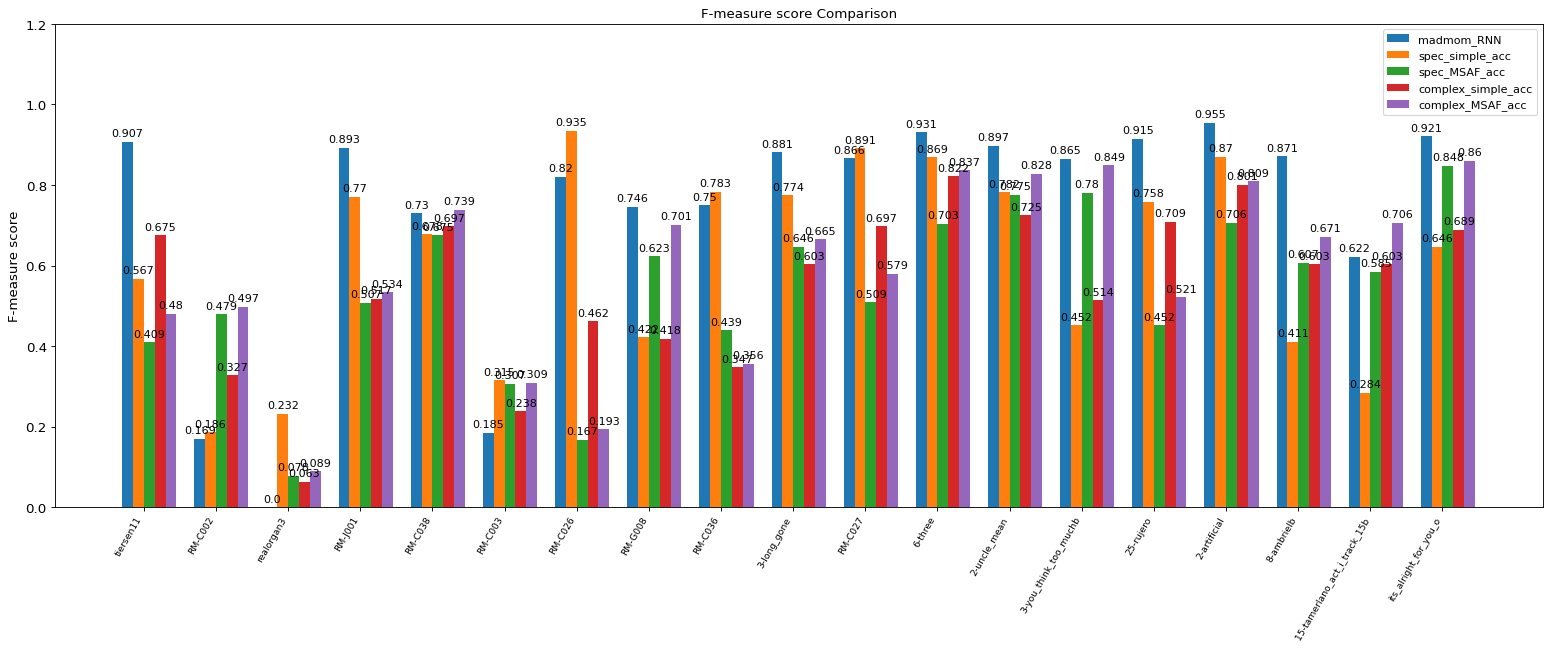

Average Precision for all dataset with madmom_RNN: 91.821
Average Recall for all dataset with madmom_RNN: 68.211
Average F-measure for all dataset with madmom_RNN: 73.284

Average Precision for all dataset with spec_simple_acc: 81.4
Average Recall for all dataset with spec_simple_acc: 53.7
Average F-measure for all dataset with spec_simple_acc: 61.184

Average Precision for all dataset with spec_MSAF_acc: 39.789
Average Recall for all dataset with spec_MSAF_acc: 98.816
Average F-measure for all dataset with spec_MSAF_acc: 54.184

Average Precision for all dataset with complex_simple_acc: 53.0
Average Recall for all dataset with complex_simple_acc: 67.789
Average F-measure for all dataset with complex_simple_acc: 55.316

Average Precision for all dataset with complex_MSAF_acc: 46.416
Average Recall for all dataset with complex_MSAF_acc: 93.747
Average F-measure for all dataset with complex_MSAF_acc: 59.068



In [ ]:
# Peak Detection parameters
thrs = 0.2
median_len = 16
offset_rel = 0.0
sigma = 1

# Madmom's RNN parameters
thrs_RNN = 0.5
smooth_factor = 0.0
combine = 0.03
fps = 100
pre_avg = 0.0 
post_avg = 0.0
pre_max = 0.0
post_max = 0.0

runExperiment(dict_annotations)

Including a smooth factor for the RNN activation function allows for increased sensitivity. This brings down the Precision due to an increase in false positives, but substantially improves Recall due to a lower number of false negatives. This value should be kept low enough, otherwise the RNN becomes overly sensitive and the Precision falls drastically.

File number:   0%|          | 0/19 [00:00<?, ?it/s]

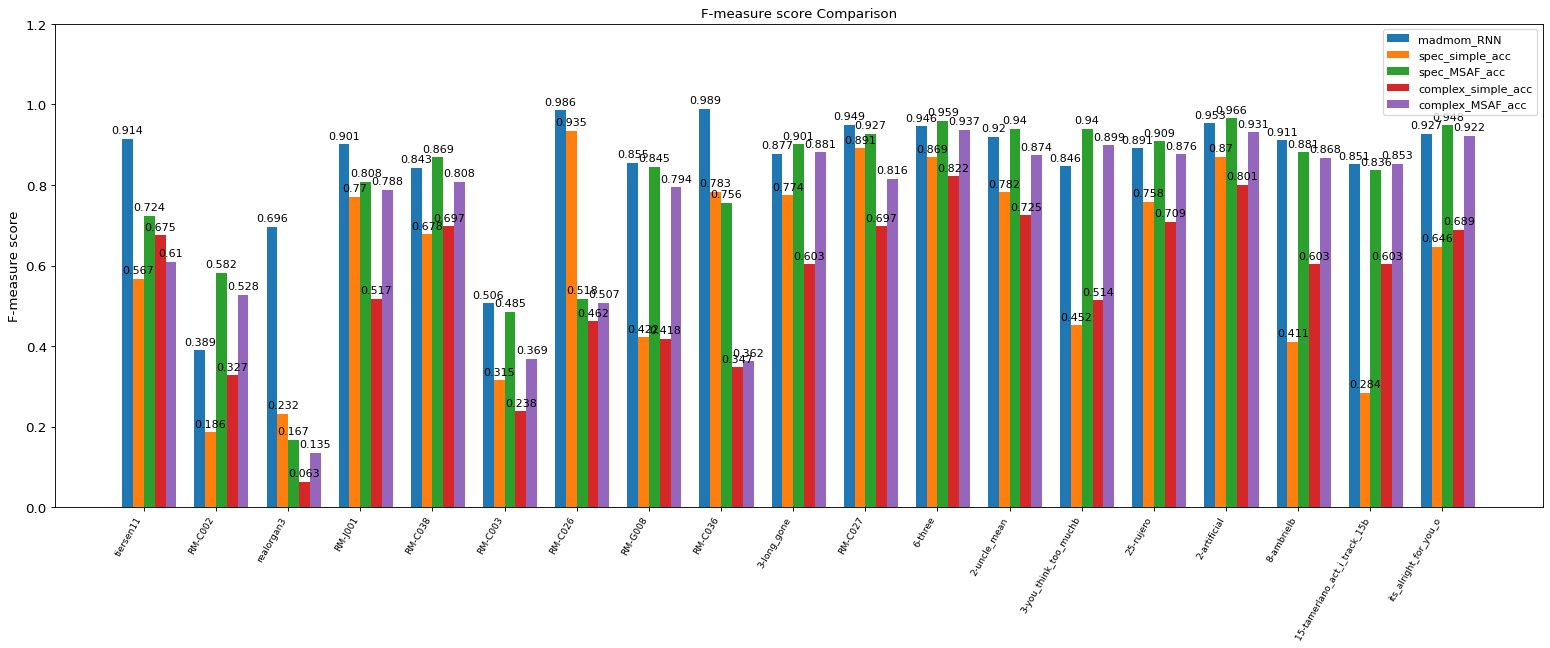

Average Precision for all dataset with madmom_RNN: 87.705
Average Recall for all dataset with madmom_RNN: 85.563
Average F-measure for all dataset with madmom_RNN: 85.0

Average Precision for all dataset with spec_simple_acc: 81.4
Average Recall for all dataset with spec_simple_acc: 53.7
Average F-measure for all dataset with spec_simple_acc: 61.184

Average Precision for all dataset with spec_MSAF_acc: 73.284
Average Recall for all dataset with spec_MSAF_acc: 91.353
Average F-measure for all dataset with spec_MSAF_acc: 78.742

Average Precision for all dataset with complex_simple_acc: 53.0
Average Recall for all dataset with complex_simple_acc: 67.789
Average F-measure for all dataset with complex_simple_acc: 55.316

Average Precision for all dataset with complex_MSAF_acc: 69.789
Average Recall for all dataset with complex_MSAF_acc: 80.584
Average F-measure for all dataset with complex_MSAF_acc: 72.411



In [ ]:
# Peak Detection parameters
thrs = 0.2
median_len = 32
offset_rel = 0.2
sigma = 2

# Madmom's RNN parameters
thrs_RNN = 0.5
smooth_factor = 0.05
combine = 0.03
fps = 100
pre_avg = 0.0 
post_avg = 0.0
pre_max = 0.0
post_max = 0.0

runExperiment(dict_annotations)

By allowing the RNN to detect for local maxima and adjusting both the detection threshold and the window for reporting one onset, the F-measure can be ramped up to almost 0.88, greatly improving over the rest of the onset detection methods.

File number:   0%|          | 0/19 [00:00<?, ?it/s]

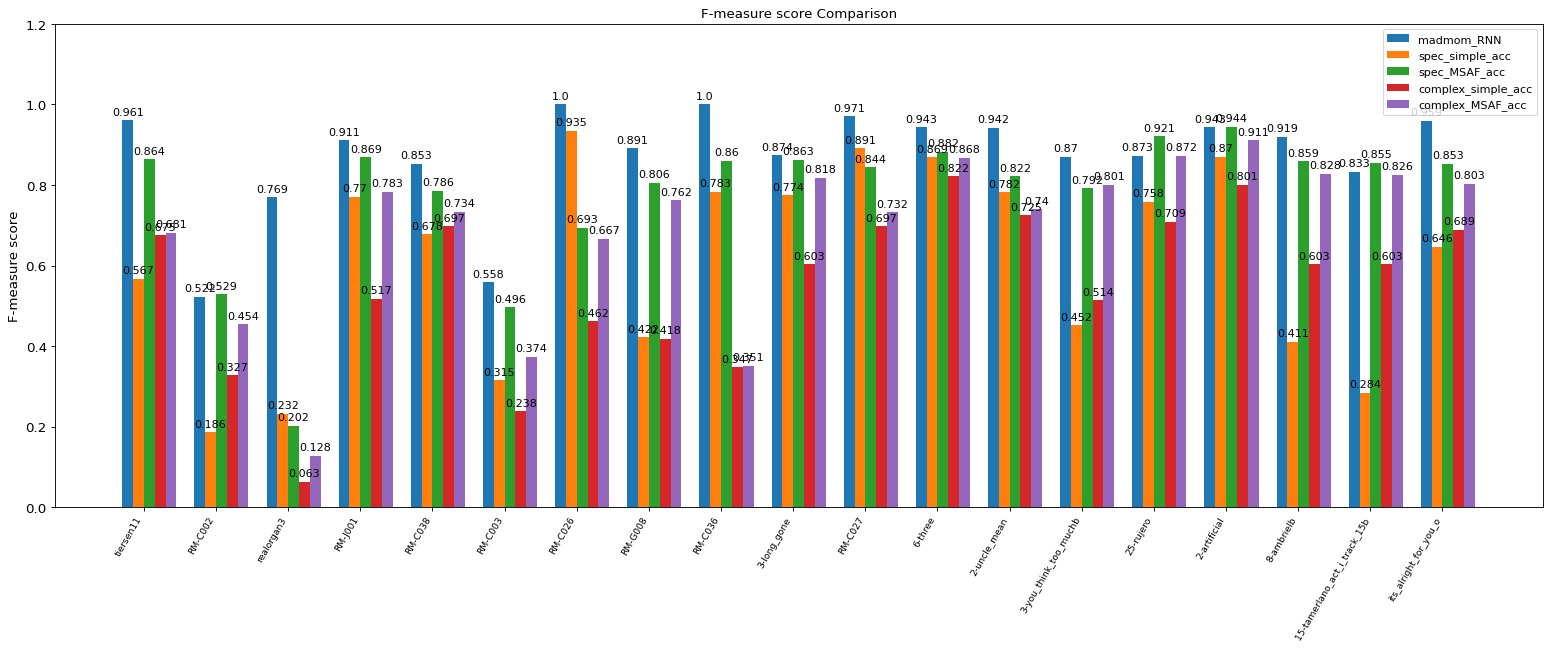

Average Precision for all dataset with madmom_RNN: 89.253
Average Recall for all dataset with madmom_RNN: 87.374
Average F-measure for all dataset with madmom_RNN: 87.326

Average Precision for all dataset with spec_simple_acc: 81.4
Average Recall for all dataset with spec_simple_acc: 53.7
Average F-measure for all dataset with spec_simple_acc: 61.184

Average Precision for all dataset with spec_MSAF_acc: 82.321
Average Recall for all dataset with spec_MSAF_acc: 77.174
Average F-measure for all dataset with spec_MSAF_acc: 77.579

Average Precision for all dataset with complex_simple_acc: 53.0
Average Recall for all dataset with complex_simple_acc: 67.789
Average F-measure for all dataset with complex_simple_acc: 55.316

Average Precision for all dataset with complex_MSAF_acc: 75.726
Average Recall for all dataset with complex_MSAF_acc: 67.242
Average F-measure for all dataset with complex_MSAF_acc: 69.121



In [ ]:
# Peak Detection parameters
thrs = 0.2
median_len = 64
offset_rel = 0.1
sigma = 4

# Madmom's RNN parameters
thrs_RNN = 0.4
smooth_factor = 0.05
combine = 0.05
fps = 100
pre_avg = 0.0
post_avg = 0.0
pre_max = 1./fps
post_max = 1./fps

runExperiment(dict_annotations)

It is important to note that for the case of both the spectral and complex-novelty function methods, using the adaptive threshold (MSAF) gives better overall results since it will work independently for each file, as opposed to setting a constant threshold for each audio sample; this helps when working with multiple files in a dataset, as opposed to working with a single file. 

However, results also show that the Spectral-Based Novelty obtained better metrics than the Complex-Based Novelty function. Without deep diving into each file, from the metrics it can be inferred that the weighing in of the phase information does not help identifying the true positives and can cause hyper-sensitivity, which also increases the false positives. Some fine-tuning could increase the final F-measure score, but the set of experiments run show that it is quite difficult to pinpoint a sweetspot without hurting the metrics.

### 5.2 <ins>Single-Case Analysis</ins> 

By looking at the bar plots generated for every method, three interesting files were selected for a more careful observation: '6-three', 'RM-C036', and 'realorgan3'. These three examples showcase three different behaviours:
the first one where all methods managed to get a somewhat decent onset detection overall; the second one in which the RNN managed to get a perfect detection while the Complex-Basedy methods did not have a good performance; and the third one where the results were poor overall but the RNN outclassed the rest of the methods.

The parameters were set to the last experiment where the best results were obtained. These can be modified to observe if better results can be obtained for a particular case with a particular method.

In [ ]:
# Sample parameters
frame_size_sec = 0.023
hop_size_sec = 0.01

# Novelty function parameters
gamma = 100
M_sec = 0.1

# Peak Detection parameters
thrs = 0.2
median_len = 64
offset_rel = 0.1
sigma = 4

# Madmom's RNN parameters
thrs_RNN = 0.4
smooth_factor = 0.05
combine = 0.05
fps = 100
pre_avg = 0.0
post_avg = 0.0
pre_max = 1./fps
post_max = 1./fps

#### 5.2.1 <ins>'6-three'</ins> 

The '6-three' sample is an extract of a metal-like song, which contains very defined standard patterns for its rhythmic section. The 30s audio file allows for several onsets to be detected, and all methods managed to detect the onsets and the overall structure of the gaps found in the annotations. The following set of plots show that, for this case, the spectral-based novelty with MSAF peak detection outperformed the rest, including the RNN approach.

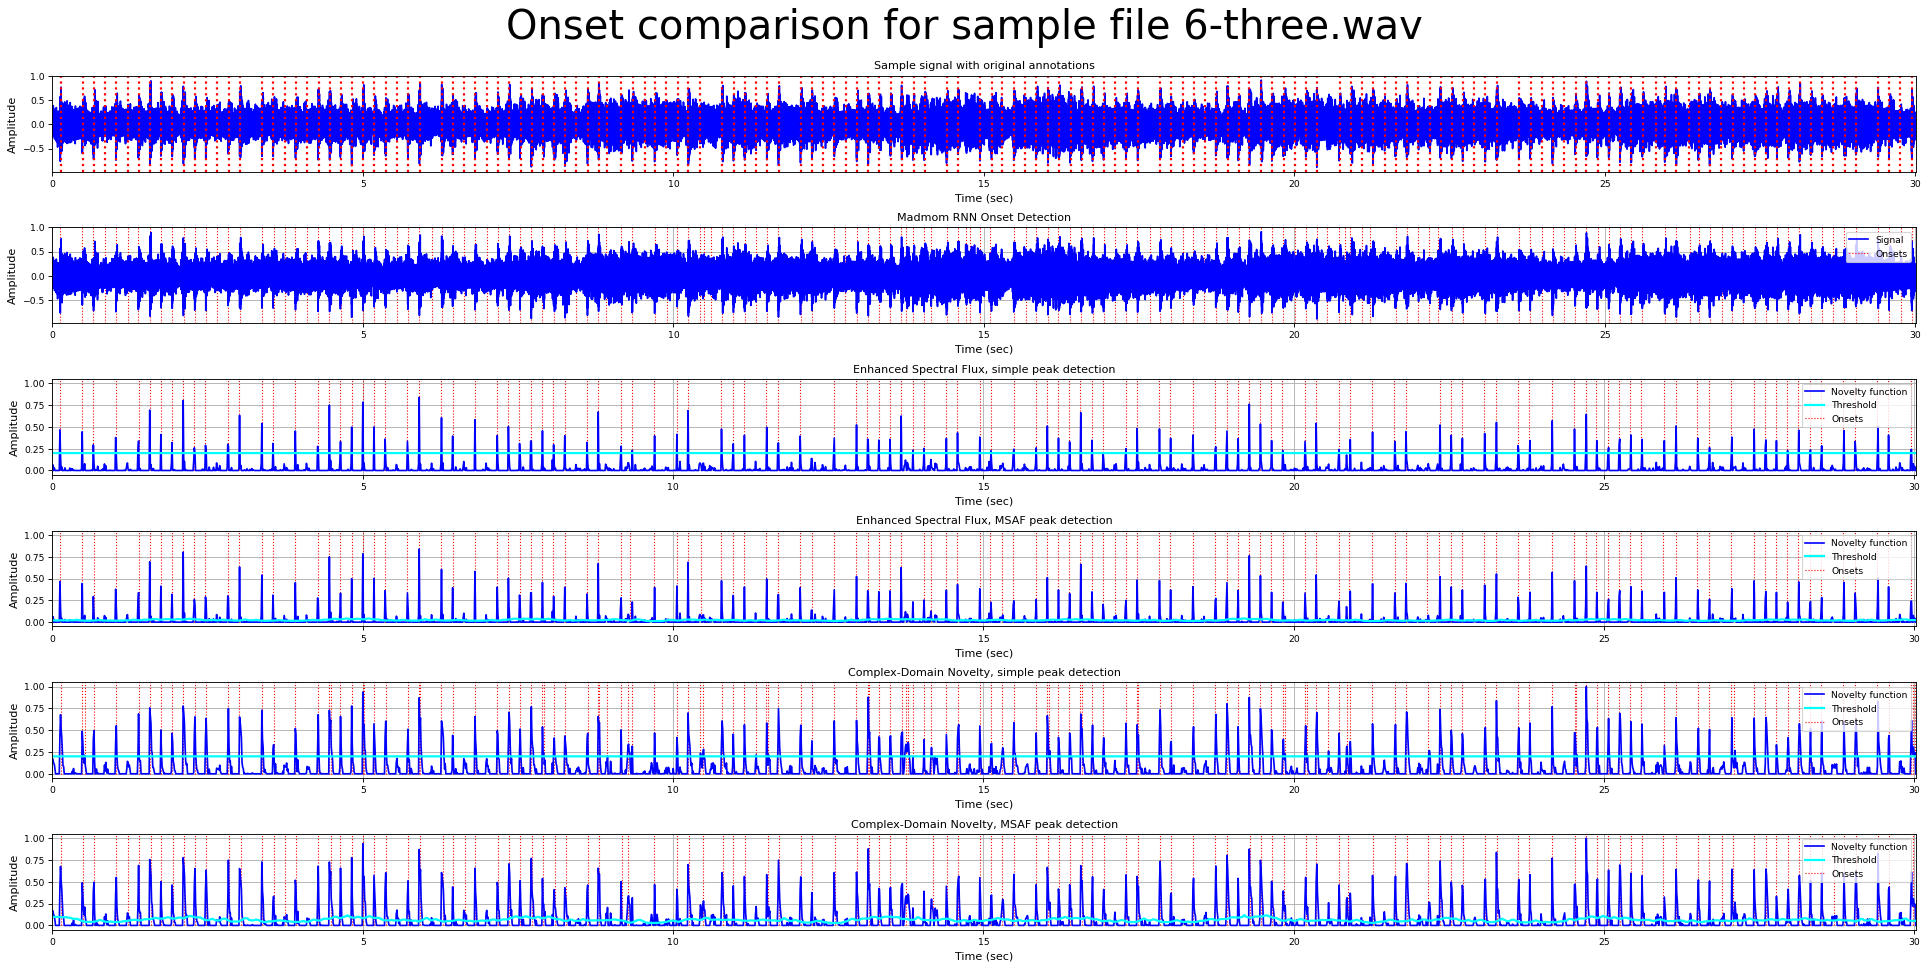

In [ ]:
filename = '6-three'
sample = Wave(AUDIO, filename + '.wav', frame_size_sec, hop_size_sec)
_ = sample.singleCaseAnalysis(play_audio=True)

By inspecting a specific section of the sample file, a closer inspection to each method's performance can be obtained. For the 10-20s section, it can be seen that there are specific onsets - such as the one around 12.5s - that none of the methods managed to detect. Also, the RNN was too sensitive and produce more false positives than Spectral-Based Novelty with MSAF, which explains the lower F-measure score.

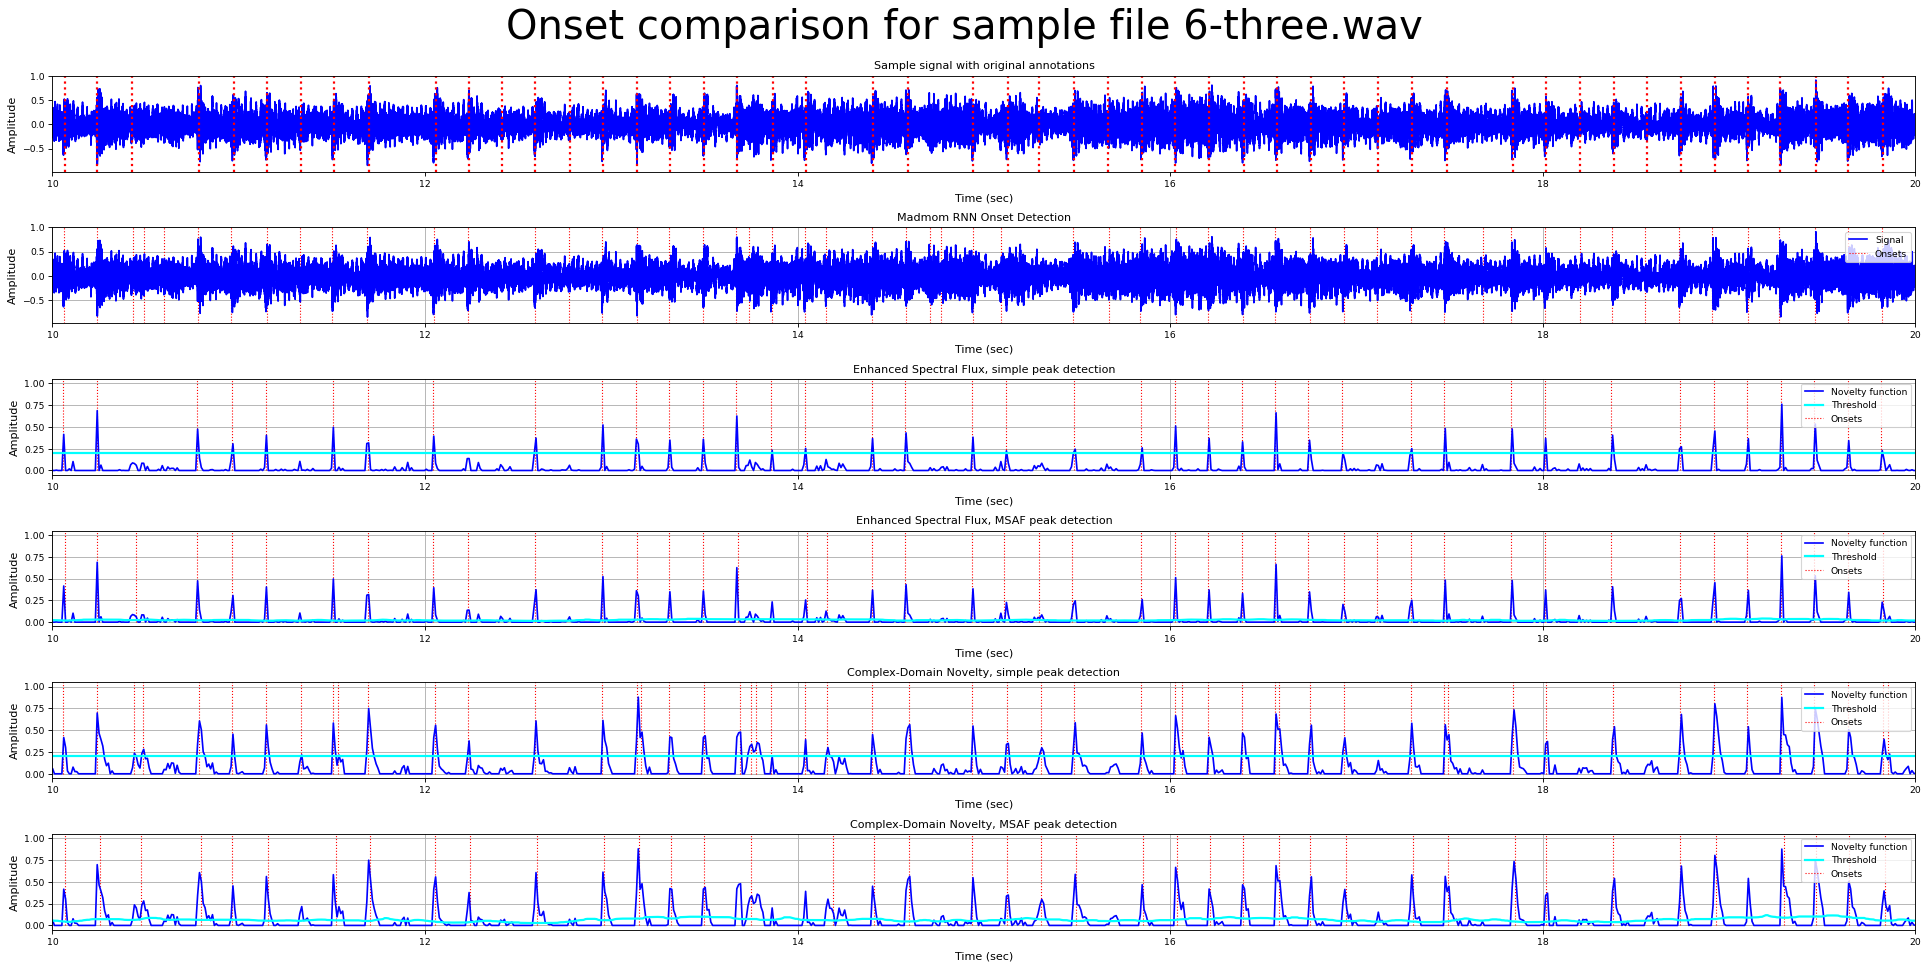

In [ ]:
filename = '6-three'
sample = Wave(AUDIO, filename + '.wav', frame_size_sec, hop_size_sec)
_ = sample.singleCaseAnalysis(time_range=(10.0, 20.0), play_audio=False)

#### 5.2.2 <ins>'RMC-036'</ins> 

'RMC-036' is a showcase of a violin with two distinct "structures": one being sustained notes and the other being a faster note progression, the latter containing the majority of the onsets.

The RNN managed to detect every single onset with a slight offset that anticipates the annotaions - this is where the evaluation window comes in handy for the metric evaluation. Spectral-Based Novelty with MSAF performed decently by identifying the onsets but had too many false positives; the case is similar for phase-based methods, but with the particulariy that the phase integration was too sensitive for the longer sustained notes.

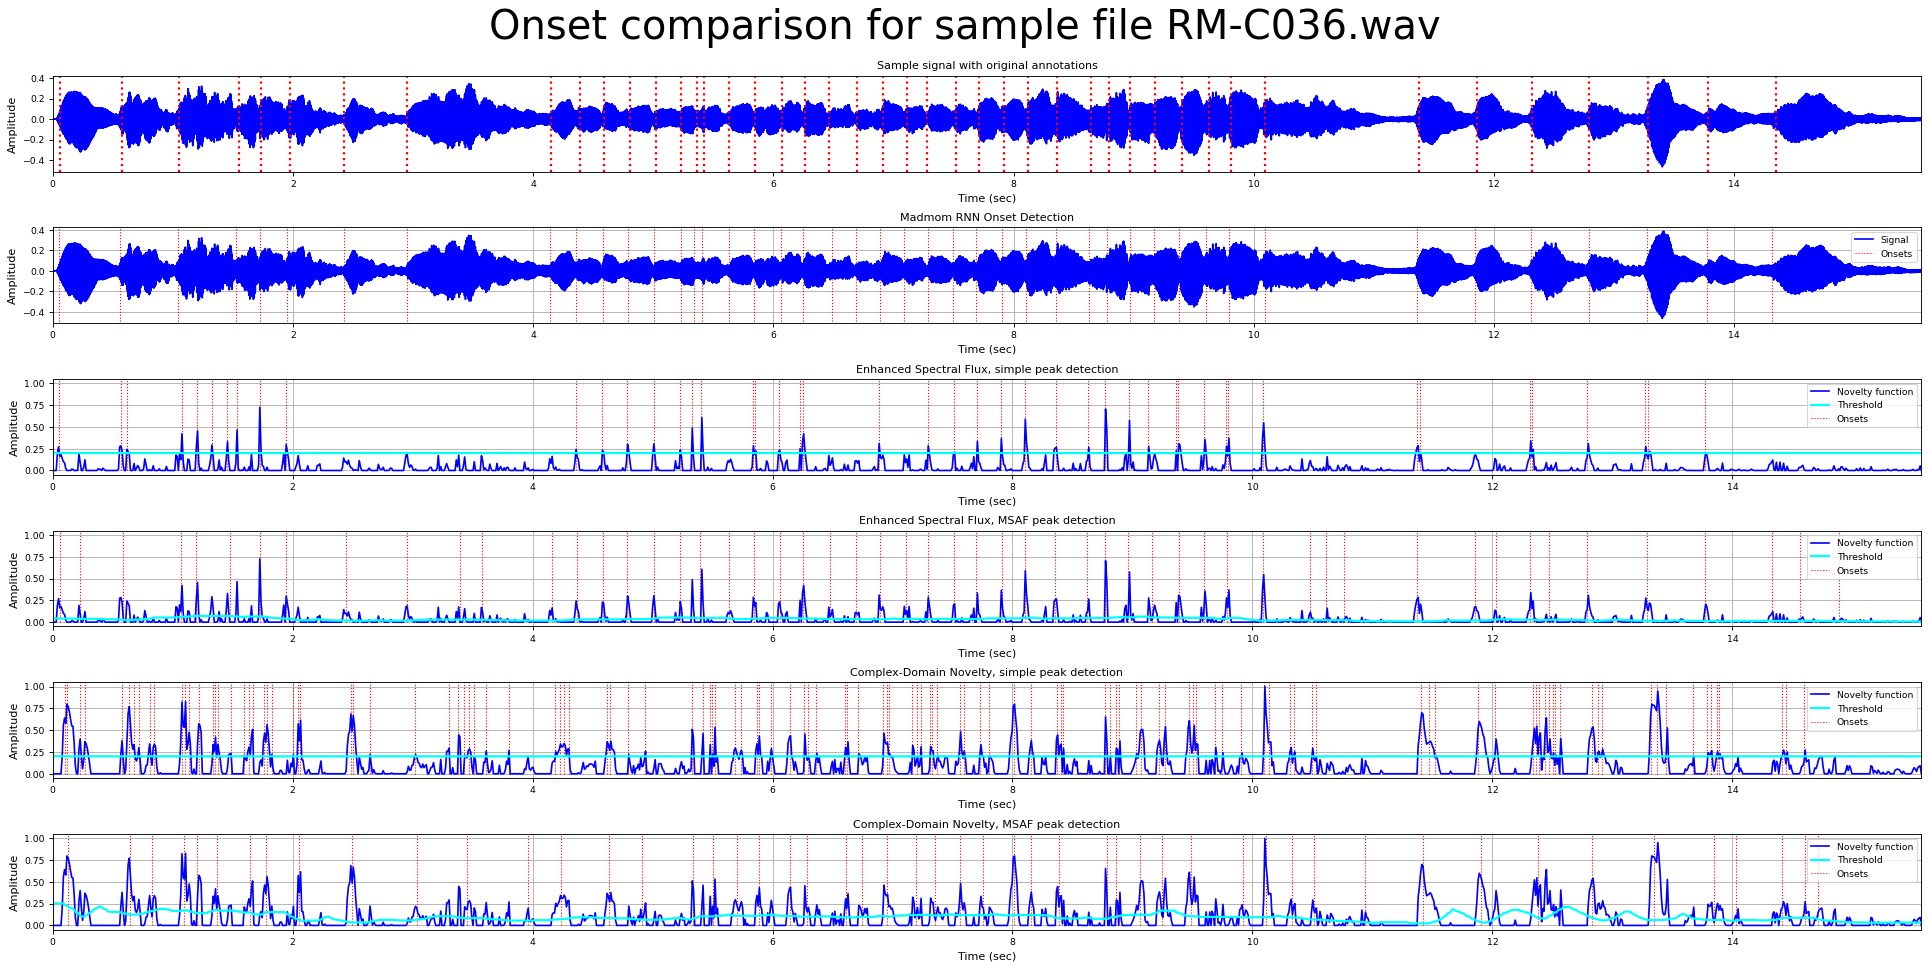

In [ ]:
filename = 'RM-C036'
sample = Wave(AUDIO, filename + '.wav', frame_size_sec, hop_size_sec)
_ = sample.singleCaseAnalysis(play_audio=True)

#### 5.2.3 <ins>'realorgan3'</ins> 

Signal from 'realorgan3' reproduces a sole organ playing sustained chords, with very few onsets identified in the annotations. This was the worst-case scenario from the entire dataset in terms of metrics. The RNN managed to identify some of the onsets but failed with others; low energy could  explain this, and a potential trend could be found in terms of the type of chords that were played. Nevertheless, it did not produce any false positives, which were the case for the other methods, either spectral-based or with the phase integration. A potential fine-tuning could improve the results, with the Spectral-Based Novelty with MSAF having a better prospect.

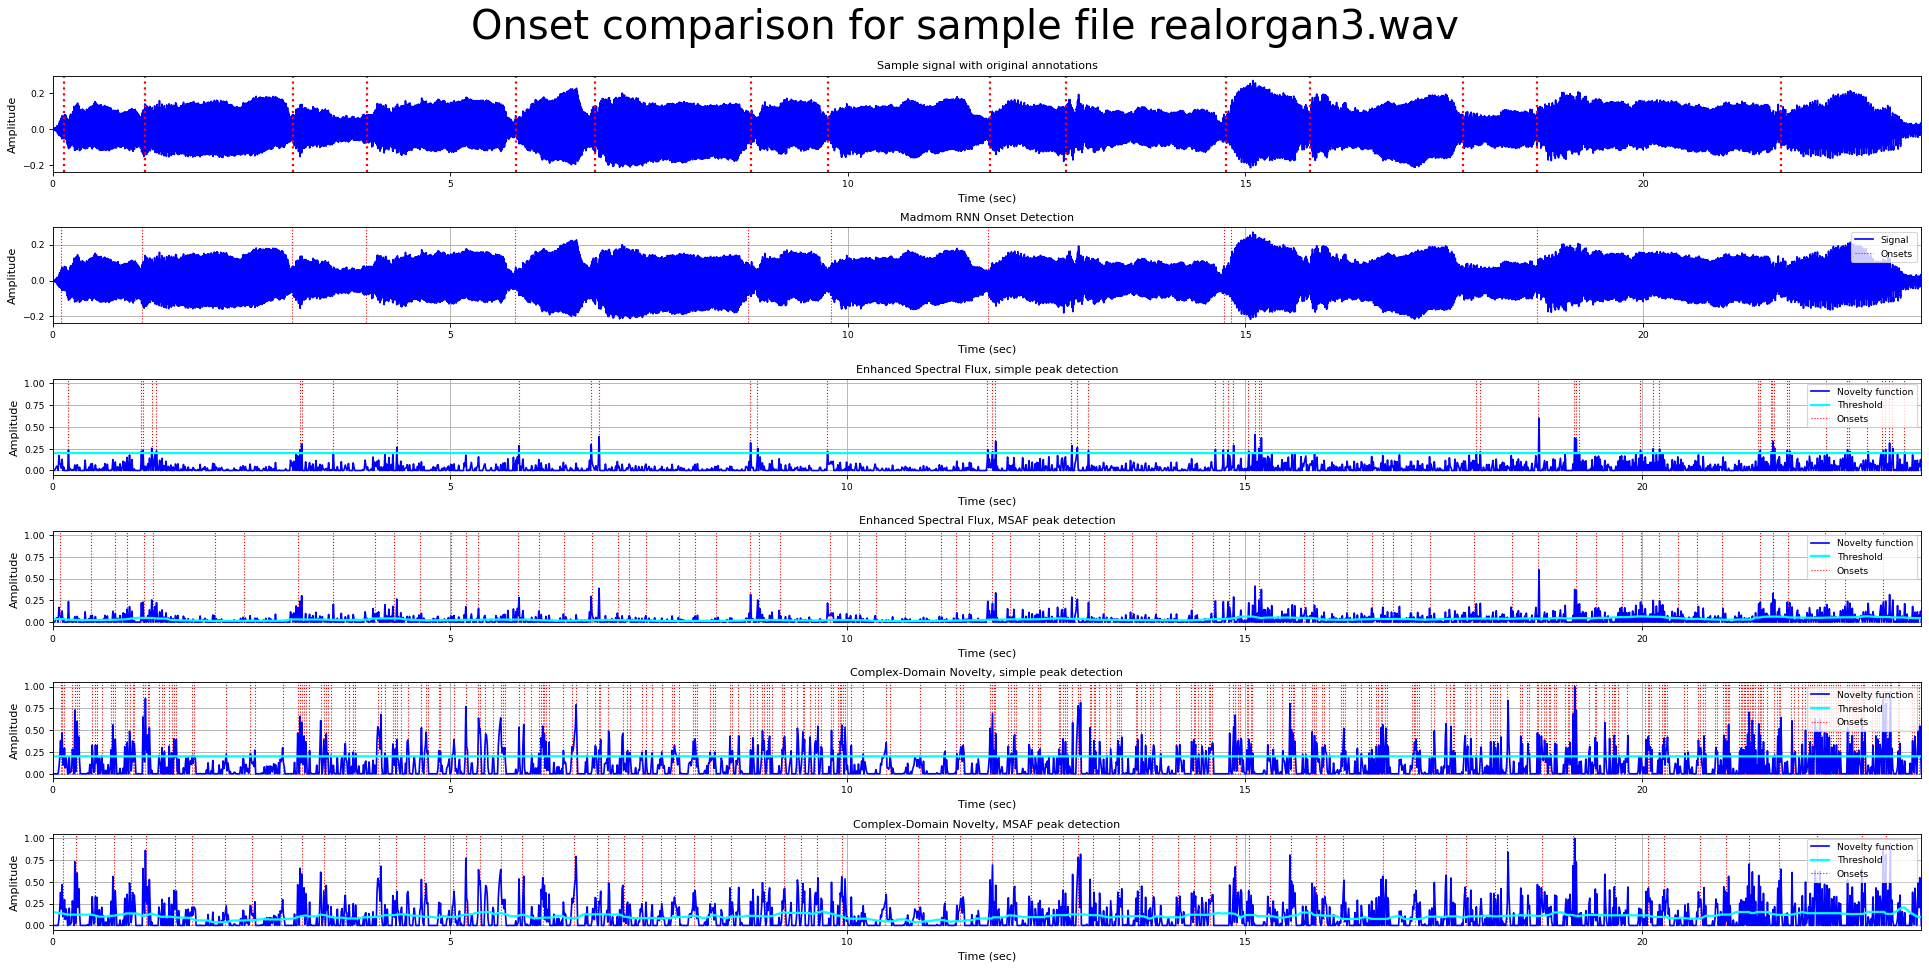

In [ ]:
filename = 'realorgan3'
sample = Wave(AUDIO, filename + '.wav', frame_size_sec, hop_size_sec)
_ = sample.singleCaseAnalysis(play_audio=True)

## **6. Conclusions**

Experimentation results show that out of the compared techniques, the use of deep-learning techniques such as RNN can give overall better results when applied to datasets that contain difficult sample files. However, such deep-learning models also have their own limitations and need proper calibration. Nevertheless, a more simple approach such as the Spectral-Based Novelty with an averaging threshold can outperform the RNN in many cases, without the need for training a model. This is limited to offline analysis, and online analysis can present other challenges that might need more refinement in terms of feedback/feedfoward moving averages, which also limits what kind of RNN model can be used.

The other set of techniques have their own set of limitations. Simple thresholding can be used for sample files that have very identifiable patterns but seem to suffer with sustained notes/chords, and overall does not seem feasible to use for large datasets since a threshold would have to be defined for each file, needing a more defined approach for each case. MSAF seems to solve this problem since the threshold is no longer defined by the user, which is convenient for several sample files in a dataset; it still needs some refining and can be overly sensitive, increasing the amount of false positives which reduces the precision metric, thus hurting the F-measure score.

Also surprisingly, the Complex-Based Novelty function does not bring any redeemable advantages over the Spectral-Based Novelty, at least for this dataset. Using phase information could in theory bring a more refined approach for analysis and for a more precise onset detection, but in the analyzed cases it reported a worse performance in both Precision and Recall, which means that not only onset detection was subpar but also that more false positives were detected.

Finally, more refined results could be obtained by finding optimal values, either for the whole dataset or for a specific file. Further experimentation could be included that sweeps values for specific parameters in order to improve the scores; this experiments could focus only on MSAF peak detection and in the RNN since it is clear that both give better results overall and are easier to implement for datasets, thus limiting the number of parameters that need to be optimized. Also, this could be expanded to other availabe datasets that have the annotations available.


## **7. References**

>[1] Böck, S., Korzeniowski, F., Schlüter, J., Krebs, F., & Widmer, G. (2016). *Madmom: A new Python Audio and Music Signal Processing Library*. Proceedings of the 24th ACM International Conference on Multimedia. doi:10.1145/2964284.2973795

>[2] Müller, M. (2016). *Fundamentals of Music Processing: Audio, analysis, algorithms, applications*. SPRINGER.

>[3] Böck, S., Krebs, F., & Schedl, M. (2012, October). *Evaluating the Online Capabilities of Onset Detection Methods*. In ISMIR (pp. 49-54).

>[4] Pattern Recognition and Artificial Intelligence Group, Universidad de Alicante. (2009). ODB (onset detection database). Retrieved 2021, from https://grfia.dlsi.ua.es/cm/projects/prosemus/database.php.
>[5] International Audio Laboratories Erlangen(n.d.). Chapter 6: Tempo and Beat Tracking. Retrieved 2021, from https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6.html